In [1]:
!pip install -U tensorly

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

import sklearn
from sklearn.preprocessing import normalize

from IPython.display import Image, display
from torch.autograd import Variable

import tensorly as tl
import numpy as np
from tensorly.tenalg import inner
from tensorly.random import check_random_state
from tensorly.decomposition import parafac


tl.set_backend('numpy')

device = 'cuda' if torch.cuda.is_available() else 'cpu'    #CPU or GPU
print(device)



Requirement already up-to-date: tensorly in /usr/local/lib/python3.6/dist-packages (0.4.5)
cuda


In [2]:
### PART A
print('PART A')
class CPD():
  #Whitening function
  def whiten(tensor, matrix, rank):
    gamma, U = np.linalg.eig(matrix)
    idx = gamma.argsort()[::-1] 
    gamma = gamma[idx[:rank]]
    U = U[:, idx[:rank]]

    W = U.dot(np.diag(gamma ** (-0.5)))
    dim = tensor.ndim

    W_repeated = [W] * dim
    return tl.tenalg.multi_mode_dot(tensor, [W.transpose()] * dim), W

  #Unwhitening function
  def unwhiten( V, Lambda, W):
    W_pinv = np.linalg.pinv(np.transpose(W))
    C = W_pinv.dot(V.dot(np.diag(Lambda)))
    w = Lambda ** (-2)

    return C, w

  #Power method for tensors
  def power_iteration( T1, V0, iternum):
    dim = T1.ndim
    n, m = np.shape(V0) 
    V_final = np.zeros(np.shape(V0))
    Lambda = np.zeros(m)
    err = np.zeros((m,iternum))
    
    T_current = T1;
    for k in range(m):
      v_old = V0[:,k]
      
      for count in range(iternum):
        T = tl.tenalg.multi_mode_dot(T_current, [v_old] * (dim-1), modes=range(1,dim)) 
        lambd = tl.norm(T)
        v_new = T / lambd
        err[k,count] = np.linalg.norm(v_new - v_old)
        v_old = v_new

      V_final[:,k] = v_new
      Lambda[k] = lambd
      factors = [np.reshape(v_new, (n,1))] * dim
      weights = [lambd]*1
      T_current = T_current - tl.kruskal_to_tensor((weights, factors))

    return V_final, Lambda, err



PART A


PART B
Reconstruction L2 error, err1 = 2.5775726040506885e-15
[1. 1. 1.]


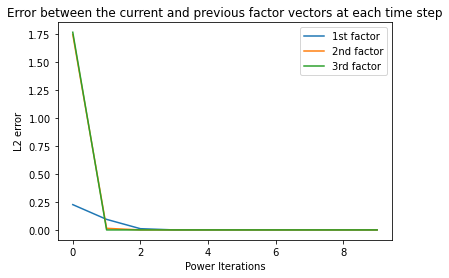

In [3]:
### PART B
print('PART B')
rank = 3 #rank is predetermined
iternum = 10 #power iterations

#load tensor and matrix
tensor1 = tl.tensor(np.load('/content/drive/My Drive/third_mmt_tensor_1.npy'))
matrix1 = np.load('/content/drive/My Drive/second_mmt_matrix_1.npy')

#perform whitening
white_tensor1, W1 = CPD.whiten(tensor1, matrix1, rank)
#randomly generate initial vectors
V0 = np.random.rand(rank, rank)
V0_norm = np.linalg.norm(V0, axis=0)
V0 = V0 / V0_norm.reshape(1,rank)
#perform power iterations
V1, Lambda1, err = CPD.power_iteration(white_tensor1, V0,  iternum)
#unwhiten the resulting factors and weights
C1, w1 = CPD.unwhiten(V1,  Lambda1, W1)

#perform reconstruction
recons_tensor1 = tl.kruskal_to_tensor((w1, [C1]*3))
#reconstruction error
err1 = tl.norm(tensor1 - recons_tensor1)
print('Reconstruction L2 error, err1 =', err1)

print(w1)

plt.figure(0)
plt.plot(range(iternum),err[0,:], label='1st factor')
plt.plot(range(iternum),err[1,:], label='2nd factor')
plt.plot(range(iternum),err[2,:], label='3rd factor')
plt.legend(loc='best')
plt.xlabel('Power Iterations')
plt.ylabel('L2 error')
plt.title('Error between the current and previous factor vectors at each time step')
plt.show()

PART C
Reconstruction L2 error, err1 = 0.4559572775975251


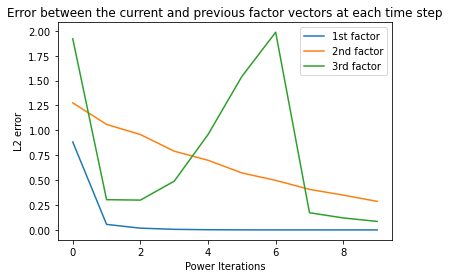

In [4]:
### PART C
print('PART C')
rank = 3 #rank is predetermined
iternum = 10 #power iterations

#load tensor and matrix
tensor1 = tl.tensor(np.load('/content/drive/My Drive/third_mmt_tensor_1.npy'))
matrix1 = np.load('/content/drive/My Drive/second_mmt_matrix_1.npy')


#randomly generate initial vectors
V0 = np.random.rand(tensor1.shape[0], rank)
V0_norm = np.linalg.norm(V0, axis=0)
V0 = V0 / V0_norm.reshape(1,rank)
#perform power iterations
V1, Lambda1, err = CPD.power_iteration(tensor1, V0,  iternum)

#perform reconstruction
recons_tensor1 = tl.kruskal_to_tensor((Lambda1, [V1]*3))
#reconstruction error
err1 = tl.norm(tensor1 - recons_tensor1)
print('Reconstruction L2 error, err1 =', err1)

plt.figure(1)
plt.plot(range(iternum),err[0,:], label='1st factor')
plt.plot(range(iternum),err[1,:], label='2nd factor')
plt.plot(range(iternum),err[2,:], label='3rd factor')
plt.legend(loc='best')
plt.xlabel('Power Iterations')
plt.ylabel('L2 error')
plt.title('Error between the current and previous factor vectors at each time step')
plt.show()

## From the previous result, we can see that the direct reconstruction error is 1E-14 times higher than the whitened reconstruction. Error plot also shows that 3rd eigenvector has some peaks over iterations. Therefore, whitening definitely helps us with CP-decomposition.



In [5]:
### PART D
print('PART D')
rank = 3 #rank is predetermined
iternum = 10 #power iterations

#load tensor and matrix
tensor1 = tl.tensor(np.load('/content/drive/My Drive/third_mmt_tensor_1.npy'))
matrix1 = np.load('/content/drive/My Drive/second_mmt_matrix_1.npy')

#perform parafac without whitening
weights_direct, factors_direct = parafac(tensor1, rank=rank)

#perform parafac with whitening/unwhitening
white_tensor1, W1 = CPD.whiten(tensor1, matrix1, rank)
weights_white, factors_white = parafac(white_tensor1, rank=rank)
factors_unwhite = []
for f_white in factors_white:
  f_unwhite, weights_unwhite = CPD.unwhiten(f_white,  weights_white, W1)
  factors_unwhite.append(f_unwhite)

#perform reconstructions
recons_tensor_direct = tl.kruskal_to_tensor((weights_direct, factors_direct))
recons_tensor_unwhite = tl.kruskal_to_tensor((weights_unwhite, factors_unwhite))

#reconstruction error
err_direct = tl.norm(tensor1 - recons_tensor_direct)
err_unwhite = tl.norm(tensor1 - recons_tensor_unwhite)

print('Direct reconstruction L2 error, err_direct =', err_direct)
print('Whitened reconstruction L2 error, err_unwhite =', err_unwhite)

PART D
Direct reconstruction L2 error, err_direct = 0.15580743954451848
Whitened reconstruction L2 error, err_unwhite = 3.749263591439465e-15


## Same as before. Direct reconstruction error with ALS is 1E+14 times higher than the whitened reconstruction with ALS. Therefore, whitening is necessary also with ALS method.



In [6]:
### PART E
print('PART E')
rank = 3 #rank is predetermined
iternum = 10 #power iterations

#load tensors and matricies
tensor2 = tl.tensor(np.load('/content/drive/My Drive/third_mmt_tensor_2.npy'))
matrix2 = np.load('/content/drive/My Drive/second_mmt_matrix_2.npy')

tensor3 = tl.tensor(np.load('/content/drive/My Drive/third_mmt_tensor_3.npy'))
matrix3 = np.load('/content/drive/My Drive/second_mmt_matrix_3.npy')

## Power Iteration and ALS methods on tensor2 and tensor3
#perform whitening
white_tensor2, W2 = CPD.whiten(tensor2, matrix2, rank)
white_tensor3, W3 = CPD.whiten(tensor3, matrix3, rank)

#randomly generate initial vectors
V0_2 = np.random.rand(rank, rank)
V0_norm_2 = np.linalg.norm(V0_2, axis=0)
V0_2 = V0_2 / V0_norm_2.reshape(1,rank)

V0_3 = np.random.rand(rank, rank)
V0_norm_3 = np.linalg.norm(V0_3, axis=0)
V0_3 = V0_3 / V0_norm_3.reshape(1,rank)

#perform power iterations
V2, Lambda2, err2 = CPD.power_iteration(white_tensor2, V0_2,  iternum)
V3, Lambda3, err3 = CPD.power_iteration(white_tensor3, V0_3,  iternum)

#perform ALS with parafac
weights_white2, factors_white2 = parafac(white_tensor2, rank=rank)
weights_white3, factors_white3 = parafac(white_tensor3, rank=rank)

#perform ALS with parafac (direct)
weights_direct2, factors_direct2 = parafac(tensor2, rank=rank)
weights_direct3, factors_direct3 = parafac(tensor3, rank=rank)

#unwhiten the resulting factors and weights
C2, w2 = CPD.unwhiten(V2, Lambda2, W2)
C3, w3 = CPD.unwhiten(V3, Lambda3, W3)

factors_unwhite2 = []
for f_white in factors_white2:
  f_unwhite, weights_unwhite2 = CPD.unwhiten(f_white, weights_white2, W2)
  factors_unwhite2.append(f_unwhite)

factors_unwhite3 = []
for f_white in factors_white3:
  f_unwhite, weights_unwhite3 = CPD.unwhiten(f_white, weights_white3, W3)
  factors_unwhite3.append(f_unwhite)

#perform reconstructions
recons_tensor_power_2 = tl.kruskal_to_tensor((w2, [C2]*3))
recons_tensor_power_3 = tl.kruskal_to_tensor((w3, [C3]*3))
recons_tensor_ALS_2 = tl.kruskal_to_tensor((weights_unwhite2, factors_unwhite2))
recons_tensor_ALS_3 = tl.kruskal_to_tensor((weights_unwhite3, factors_unwhite3))
recons_tensor_ALS_direct_2 = tl.kruskal_to_tensor((weights_direct2, factors_direct2))
recons_tensor_ALS_direct_3 = tl.kruskal_to_tensor((weights_direct3, factors_direct3))

#reconstruction error
err_power_2 = tl.norm(tensor2 - recons_tensor_power_2)
err_power_3 = tl.norm(tensor3 - recons_tensor_power_3)
err_ALS_2 = tl.norm(tensor2 - recons_tensor_ALS_2)
err_ALS_3 = tl.norm(tensor3 - recons_tensor_ALS_3)
err_ALS_direct_2 = tl.norm(tensor2 - recons_tensor_ALS_direct_2)
err_ALS_direct_3 = tl.norm(tensor3 - recons_tensor_ALS_direct_3)

print('Power method reconstruction error of 2nd tensor =', err_power_2)
print('Power method reconstruction error of 3rd tensor =', err_power_3)
print('ALS reconstruction error of 2nd tensor =', err_ALS_2)
print('ALS reconstruction error of 3rd tensor =', err_ALS_3)
print('ALS (direct) reconstruction error of 2nd tensor =', err_ALS_direct_2)
print('ALS (direct) reconstruction error of 3rd tensor =', err_ALS_direct_3)

PART E


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: ComplexWarning: Casting complex values to real discards the imaginary part


Power method reconstruction error of 2nd tensor = (5.465796725443996e-15+0j)
Power method reconstruction error of 3rd tensor = (1.8011366655873893e-13+0j)
ALS reconstruction error of 2nd tensor = (6.13468232240169e-15+0j)
ALS reconstruction error of 3rd tensor = (1.8090210487010814e-13+0j)
ALS (direct) reconstruction error of 2nd tensor = 0.025015386749586952
ALS (direct) reconstruction error of 3rd tensor = 0.9217246037203495


## It seems that increase of conditioneing number from 10 to 100 resulted in 10-fold increase in reconstruction error for both methods. However, there is no significant difference between reconstruction errors of the first and the second tensors. The power method is slightly less impacted than ALS method from changes in contitioning.

In [7]:
#PART F
print('PART F')
tl.set_backend('pytorch')

class TCL_whitener(nn.Module):
  def __init__(self, input_size, rank, initial = None , verbose=1, **kwargs):
    super(TCL_whitener, self).__init__(**kwargs)
    self.verbose = verbose

    if isinstance(input_size, int):
      self.input_size = [input_size]
    else:
      self.input_size = list(input_size)
        
    self.dim = len(self.input_size)
    self.length = self.input_size[0]

    if initial is None:
      self.whitener = nn.Parameter(tl.tensor(np.random.rand(rank, self.length)), requires_grad=True)
    else:
      self.whitener = nn.Parameter(tl.tensor(initial), requires_grad=True)
    

  def forward(self, x):
    return tl.tenalg.multi_mode_dot(x, [self.whitener] * self.dim), self.whitener

  def whitening_tensor(self):
    return self.whitener
    
  def penalty(self, order=2):
    return tl.norm(self.whitener, order) ** order

PART F


PART G
Finished Training
Minimum reconstruction error for 1st tensor =  3.8192453384399414
Minimum reconstruction error for 2nd tensor =  5.007412910461426


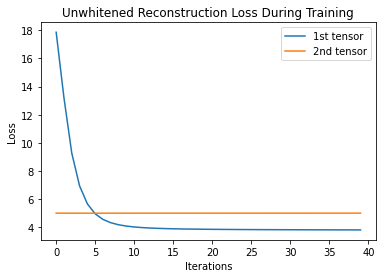

In [53]:
#PART G
print('PART G')

class CP_Net(nn.Module):
  def __init__(self, input_size, rank, initial_W = None, initial_params = None):
    super(CP_Net, self).__init__()

    self.input_size = input_size
    self.rank = rank
    self.dim = len(self.input_size)
    self.length = self.input_size[0]
    self.initial_W = initial_W
    self.initial_params = initial_params
    self.whitener = TCL_whitener(input_size = self.input_size, rank = self.rank, initial = self.initial_W)

    if self.initial_params is None:
      V = np.random.rand(rank, rank)
      V_norm = np.linalg.norm(V, axis=0)
      self.V = nn.Parameter(tl.tensor(V / V_norm.reshape(1,rank)), requires_grad=True) 
      self.Lambda = nn.Parameter(tl.tensor(np.random.rand(rank)), requires_grad=True) 
    else:
      V, Lambda = self.initial_params
      self.V = nn.Parameter(tl.tensor(V), requires_grad=True) 
      self.Lambda = nn.Parameter(tl.tensor(Lambda), requires_grad=True)
    

  def forward(self, x):
    #whiten first
    x_white, whitener_matrix = self.whitener(x)

    #reconstruct whiten version
    reconstruction_white = tl.kruskal_to_tensor((self.Lambda, [self.V]*self.rank))
    
    #unwhiten
    W_pinv = torch.pinverse(whitener_matrix)
    C = torch.mm(W_pinv,torch.mm(self.V, torch.diag(self.Lambda)))
    w = self.Lambda ** (-2)

    #reconstruct unwhiten version
    reconstruction_unwhite = tl.kruskal_to_tensor((w, [C]*self.rank))
    
    return x_white, reconstruction_white, reconstruction_unwhite




tensor1 = tl.tensor(np.load('/content/drive/My Drive/third_mmt_tensor_1.npy'))
matrix1 = np.load('/content/drive/My Drive/second_mmt_matrix_1.npy')
tensor2 = tl.tensor(np.load('/content/drive/My Drive/third_mmt_tensor_2.npy'))
matrix2 = np.load('/content/drive/My Drive/second_mmt_matrix_2.npy')
#tensor3 = tl.tensor(np.load('/content/drive/My Drive/third_mmt_tensor_3.npy'))
#matrix3 = np.load('/content/drive/My Drive/second_mmt_matrix_3.npy')



model1 = CP_Net(input_size = tensor1.shape, rank = 3)
model1 = model1.cuda() #this line is in order to use GPU
model2 = CP_Net(input_size = tensor2.shape, rank = 3)
model2 = model2.cuda() #this line is in order to use GPU
#model3 = CP_Net(input_size = tensor3.shape, rank = 3)
#model3 = model3.cuda() #this line is in order to use GPU


trainstep = 40

# Loss and optimizer
def loss_function(output, target):
  eta = 0.1
  output_x_white, output_recons_white, output_recons_unwhite = output
  loss = (eta*tl.norm(output_x_white - output_recons_white) ** 2 + tl.norm(target - output_recons_unwhite) ** 2) / target.numel();
  return loss

def recons_loss(output, target):
  _, _, output_recons_unwhite = output
  loss =  tl.norm(target - output_recons_unwhite)
  return loss

optimizer1 = optim.SGD(model1.parameters(), lr=0.0001, momentum=0.9)#, weight_decay=8e-10)
optimizer2 = optim.SGD(model2.parameters(), lr=0.0008, momentum=0.9)#, weight_decay=8e-10)
#optimizer3 = optim.SGD(model3.parameters(), lr=0.0001, momentum=0.9)#, weight_decay=8e-10)

# Train the models

loss_list_1 = []
loss_list_2 = []
#loss_list_3 = []

reg1 = 1
reg2 = 0.1
#reg3 = 1

tensor1 = tensor1.cuda(async=True)
tensor1 = Variable(tensor1)
tensor2 = tensor2.cuda(async=True)
tensor2 = Variable(tensor2)
#tensor3 = tensor3.cuda(async=True)
#tensor3 = Variable(tensor3)

for step in range(trainstep):
  # Run the forward pass
  outputs1 = model1(tensor1)
  outputs2 = model2(tensor2)
  #outputs3 = model3(tensor3)

  #compute loss
  loss1 = loss_function(outputs1, tensor1) + reg1*model1.whitener.penalty()
  loss_list_1.append(recons_loss(outputs1, tensor1).item())

  loss2 = loss_function(outputs2, tensor2) + reg2*model2.whitener.penalty()
  loss_list_2.append(recons_loss(outputs2, tensor2).item())

  #loss3 = loss_function(outputs3, tensor3) + reg3*model3.whitener.penalty()
  #loss_list_3.append(recons_loss(outputs3, tensor3).item())


  # Backprop 
  optimizer1.zero_grad()
  loss1.backward()
  optimizer1.step()

  optimizer2.zero_grad()
  loss2.backward()
  optimizer2.step()

  #optimizer3.zero_grad()
  #loss3.backward()
  #optimizer3.step()


  #Normalize V
  V1_norm = torch.norm(model1.V, dim=0)
  V2_norm = torch.norm(model2.V, dim=0)
  #V3_norm = torch.norm(model3.V, dim=0)

  model1.V.data = model1.V / V1_norm.reshape(1,model1.rank)
  model2.V.data = model2.V / V2_norm.reshape(1,model2.rank)
  #model3.V.data = model3.V / V3_norm.reshape(1,model3.rank)

print('Finished Training')

print('Minimum reconstruction error for 1st tensor = ', min(loss_list_1))
print('Minimum reconstruction error for 2nd tensor = ', min(loss_list_2))
#print('Minimum reconstruction error for 3rd tensor = ', min(loss_list_3))

plt.figure(2)
plt.plot(range(trainstep),loss_list_1, label='1st tensor')
plt.plot(range(trainstep),loss_list_2, label='2nd tensor')
#plt.plot(range(trainstep),loss_list_3, label='3rd tensor')
plt.legend(loc='best')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Unwhitened Reconstruction Loss During Training')
plt.show()

## The success of this algorithm is higly dependent on hyperparameter tuning such as learning rate and regularizer coefficients. After tuning these hyperparameters as much as possible, the errors are 1E+15 times higher than power method CP-decomposition. Results can be improved by fine-tuning the hyperparameters. Note that for some cases the whitening matrix grows indefinetely and the scpirt raises error. Re-run in that case until it works. Although I penalized the norm of whitening matrix to overcome this problem, it still can cause issues.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: ComplexWarning: Casting complex values to real discards the imaginary part


Finished Training
Minimum reconstruction error for 1st tensor =  7.673374398109445e-07
Minimum reconstruction error for 2nd tensor =  9.084033081308007e-07


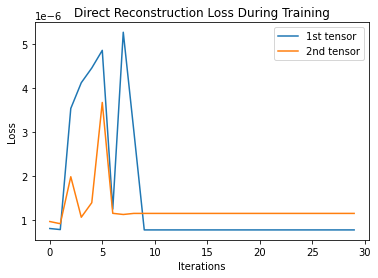

In [54]:
rank = 3

tl.set_backend('numpy')
tensor1 = tl.tensor(np.load('/content/drive/My Drive/third_mmt_tensor_1.npy'))
matrix1 = np.load('/content/drive/My Drive/second_mmt_matrix_1.npy')
tensor2 = tl.tensor(np.load('/content/drive/My Drive/third_mmt_tensor_2.npy'))
matrix2 = np.load('/content/drive/My Drive/second_mmt_matrix_2.npy')
#tensor3 = tl.tensor(np.load('/content/drive/My Drive/third_mmt_tensor_3.npy'))
#matrix3 = np.load('/content/drive/My Drive/second_mmt_matrix_3.npy')


#perform whitening
white_tensor1, W1 = CPD.whiten(tensor1, matrix1, rank)
white_tensor2, W2 = CPD.whiten(tensor2, matrix2, rank)
#white_tensor3, W3 = CPD.whiten(tensor2, matrix3, rank)
#randomly generate initial vectors
V0_1 = np.random.rand(rank, rank)
V0_norm_1 = np.linalg.norm(V0_1, axis=0)
V0_1 = V0_1/ V0_norm_1.reshape(1,rank)

V0_2 = np.random.rand(rank, rank)
V0_norm_2 = np.linalg.norm(V0_2, axis=0)
V0_2 = V0_2/ V0_norm_2.reshape(1,rank)

#V0_3 = np.random.rand(rank, rank)
#V0_norm_2 = np.linalg.norm(V0_3, axis=0)
#V0_3 = V0_3/ V0_norm_3.reshape(1,rank)


#perform power iterations
V1, Lambda1, _ = CPD.power_iteration(white_tensor1, V0_1,  iternum)
V2, Lambda2, _ = CPD.power_iteration(white_tensor2, V0_2,  iternum)
#V3, Lambda3, _ = CPD.power_iteration(white_tensor3, V0_3,  iternum)

tl.set_backend('pytorch')
tensor1 = tl.tensor(np.load('/content/drive/My Drive/third_mmt_tensor_1.npy'))
matrix1 = np.load('/content/drive/My Drive/second_mmt_matrix_1.npy')
tensor2 = tl.tensor(np.load('/content/drive/My Drive/third_mmt_tensor_2.npy'))
matrix2 = np.load('/content/drive/My Drive/second_mmt_matrix_2.npy')
#tensor3 = tl.tensor(np.load('/content/drive/My Drive/third_mmt_tensor_3.npy'))
#matrix3 = np.load('/content/drive/My Drive/second_mmt_matrix_3.npy')

model1 = CP_Net(input_size = tensor1.shape, rank = 3, initial_W = np.float64(W1.transpose()), initial_params = (np.float64(V1), np.float64(Lambda1)))
model1 = model1.cuda() #this line is in order to use GPU
model2 = CP_Net(input_size = tensor2.shape, rank = 3, initial_W = np.float64(W2.transpose()), initial_params = (np.float64(V2), np.float64(Lambda2)))
model2 = model2.cuda() #this line is in order to use GPU
#model3 = CP_Net(input_size = tensor3.shape, rank = 3, initial_W = np.float64(W3), initial_params = (np.float64(V3), np.float64(Lambda3)))
#model3 = model3.cuda() #this line is in order to use GPU


trainstep = 30

# Loss and optimizer
def loss_function(output, target):
  eta = 0.1
  output_x_white, output_recons_white, output_recons_unwhite = output
  loss = (eta*tl.norm(output_x_white - output_recons_white ) ** 2 + tl.norm(target - output_recons_unwhite ) ** 2) / target.numel();
  return loss

def recons_loss(output, target):
  _, _, output_recons_unwhite = output
  loss =  tl.norm(target - output_recons_unwhite )
  return loss

optimizer1 = optim.SGD(model1.parameters(), lr=0.1)#, momentum=0.9)#, weight_decay=8e-10)
optimizer2 = optim.SGD(model2.parameters(), lr=0.4)#, momentum=0.9)#, weight_decay=8e-10)
#optimizer3 = optim.SGD(model3.parameters(), lr=0.0001, momentum=0.9)#, weight_decay=8e-10)

# Train the models

loss_list_1 = []
loss_list_2 = []
#loss_list_3 = []

reg1 = 0
reg2 = 0
#reg3 = 1

tensor1 = tensor1.cuda(async=True)
tensor1 = Variable(tensor1)
tensor2 = tensor2.cuda(async=True)
tensor2 = Variable(tensor2)
#tensor3 = tensor3.cuda(async=True)
#tensor3 = Variable(tensor3)

for step in range(trainstep):
  # Run the forward pass
  outputs1 = model1(tensor1)
  outputs2 = model2(tensor2)
  #outputs3 = model3(tensor3)

  #compute loss
  loss1 = loss_function(outputs1, tensor1) + reg1*model1.whitener.penalty()
  loss_list_1.append(recons_loss(outputs1, tensor1).item())

  loss2 = loss_function(outputs2, tensor2) + reg2*model2.whitener.penalty()
  loss_list_2.append(recons_loss(outputs2, tensor2).item())

  #loss3 = loss_function(outputs3, tensor3) + reg3*model3.whitener.penalty()
  #loss_list_3.append(recons_loss(outputs3, tensor3).item()))


  # Backprop 
  optimizer1.zero_grad()
  loss1.backward()
  optimizer1.step()

  optimizer2.zero_grad()
  loss2.backward()
  optimizer2.step()

  #optimizer3.zero_grad()
  #loss3.backward()
  #optimizer3.step()


  #Normalize V
  V1_norm = torch.norm(model1.V, dim=0)
  V2_norm = torch.norm(model2.V, dim=0)
  #V3_norm = torch.norm(model3.V, dim=0)

  model1.V.data = model1.V / V1_norm.reshape(1,model1.rank)
  model2.V.data = model2.V / V2_norm.reshape(1,model2.rank)
  #model3.V.data = model3.V / V3_norm.reshape(1,model3.rank)

print('Finished Training')

print('Minimum reconstruction error for 1st tensor = ', min(loss_list_1))
print('Minimum reconstruction error for 2nd tensor = ', min(loss_list_2))
#print('Minimum reconstruction error for 3rd tensor = ', min(loss_list_3))

plt.figure(2)
plt.plot(range(trainstep),loss_list_1, label='1st tensor')
plt.plot(range(trainstep),loss_list_2, label='2nd tensor')
plt.legend(loc='best')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Direct Reconstruction Loss During Training')
plt.show()


## As the optimization started already with new-optimal parameters instead of random initilization, SGD converged very quickly back again to this initial parameter configuration after jiggling arraound for a brief time. When learning rate is decreased, SGD doesn't even chnage it's optimality position. I conclude that the network implementation of CP-decomposition is higly susceptible to initilization scheme.